## Import training/test files in Pandas

In [1]:
import pandas as pd
import os 

print(os.getcwd())

/Users/eren-shin/Desktop/multi-task-learning


In [2]:
train_data = pd.read_csv(os.path.join(os.getcwd() + '/data/training_csv'))
test_data = pd.read_csv(os.path.join(os.getcwd() + '/data/test_csv'))

In [3]:
# Note: we are enabling eager execution for debugging!

import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
# Example code for handling datasets
import matplotlib.pyplot as plt

# Load filenames and labels
filenames = tf.constant(train_data.iloc[:, 0].tolist())
labels = tf.constant(train_data.iloc[:, 1:].values)

# Add to a dataset object
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# We can debug using eager execution
for img, labels in dataset.batch(4).take(1):
    print(img)
    print(labels)

NameError: name 'tf' is not defined

In [5]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.

def _parse_function(filename, label):
    print(filename)
    image_string = tf.read_file(filename) 
    print(image_string)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3) # Channels needed because some test images are b/w
    image_resized = tf.image.resize_images(image_decoded, [160, 160])
    image_shape = tf.cast(tf.shape(image_decoded), tf.float32)
#     label = tf.concat([label[:]], axis=0)
    return {"x": image_resized}, label

## Make Dataset

In [15]:
# This snippet is adapted from here: https://www.tensorflow.org/guide/datasets
def input_fn(dataframe, is_eval=False):

    # Load the list of files
    filenames = tf.constant(dataframe.iloc[:, 0].tolist())

    # Load the labels
    labels = tf.constant(dataframe.iloc[:, 1:].values)

    # Build the dataset with image processing on top of it
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)

    # Add shuffling and repeatition if training
    if is_eval:
        dataset = dataset.batch(64)
    else:
        dataset = dataset.repeat().shuffle(1000).batch(64)

    return dataset

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
tf.Tensor([1], shape=(1,), dtype=int64)
tf.Tensor([4], shape=(1,), dtype=int64)


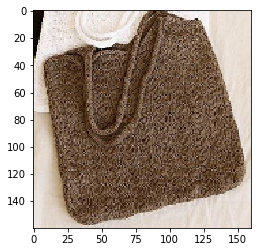

In [16]:
# Check the image & some labels
import matplotlib.pyplot as plt
for (imgs, labels) in input_fn(train_data, is_eval=True).take(1):
    plt.imshow(imgs['x'][0] / 255)
    print(labels[0])
    print(labels[1])

## Standard classical estimator (single-task only!)

### Reimplement the feature extraction from the original paper

In [17]:
def extract_features(features):
    # Input layer
    input_layer = tf.reshape(features["x"], [-1, 160, 160, 3])

    # First convolutive layer
    conv1 = tf.layers.conv2d(inputs=input_layer, filters=16, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Second convolutive layer
    conv2 = tf.layers.conv2d(inputs=pool1, filters=48, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Third convolutive layer
    conv3 = tf.layers.conv2d(inputs=pool2, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    
    # Fourth convolutive layer
    conv4 = tf.layers.conv2d(inputs=pool3, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)
    
    # Fifth convolutive layer
    conv5 = tf.layers.conv2d(inputs=pool4, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool5 = tf.layers.max_pooling2d(inputs=conv5, pool_size=[2, 2], strides=2)

    # Fourth convolutive layer
    conv4 = tf.layers.conv2d(inputs=pool3, filters=128, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)

    # Dense Layer
    flat = tf.reshape(conv4, [-1, 20 * 20 * 128])
    dense = tf.layers.dense(inputs=flat, units=100, activation=tf.nn.relu)
  
    return dense

### single task cnn model

In [18]:
# Adapted from here: https://www.tensorflow.org/tutorials/layers
def single_task_cnn_model_fn(features, labels, mode):
  
    # Get features
    dense = extract_features(features)
  
    # Make predictions
    logits = tf.layers.dense(inputs=dense, units=9)

    predicted_class = tf.argmax(logits, 1)
    
    outputs = {
        "predicted_class": predicted_class,
        "probabilities": tf.nn.softmax(logits),
        "logits": logits
    }

    # We just want the predictions
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=outputs)

    # If not in mode.PREDICT, compute the loss 
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels[:], logits=logits)

    # Single optimization step
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # If not PREDICT or TRAIN, then we are evaluating the model
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(
            labels=labels[:], predictions=outputs["predicted_class"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=metrics)

### Build the Estimator

In [19]:
single_task_classifier = tf.estimator.Estimator(
    model_fn=single_task_cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpv766fv51', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f04841ddfd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train & evaluate & test model

In [20]:
# Train the model
single_task_classifier.train(input_fn=lambda: input_fn(train_data), steps=30000)

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
INFO:tensorflow:Calling model_fn.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpv766fv51/model.ckpt.


InvalidArgumentError: Received a label value of 9 which is outside the valid range of [0, 9).  Label values: 2 3 9 3 1 7 7 1 2 1 4 6 4 3 5 1 8 8 8 8 9 2 1 6 8 5 9 4 5 9 7 6 1 2 1 7 2 8 4 9 5 1 7 4 6 7 4 9 7 9 1 3 6 6 3 5 7 4 1 2 9 4 4 5
	 [[node sparse_softmax_cross_entropy_loss/xentropy/xentropy (defined at <ipython-input-18-8f800241ee49>:23) ]]

Errors may have originated from an input operation.
Input Source operations connected to node sparse_softmax_cross_entropy_loss/xentropy/xentropy:
 dense_1/BiasAdd (defined at <ipython-input-18-8f800241ee49>:8)

Original stack trace for 'sparse_softmax_cross_entropy_loss/xentropy/xentropy':
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-cf876a7ca2dc>", line 2, in <module>
    single_task_classifier.train(input_fn=lambda: input_fn(train_data), steps=30000)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 367, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1158, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1188, in _train_model_default
    features, labels, ModeKeys.TRAIN, self.config)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1146, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "<ipython-input-18-8f800241ee49>", line 23, in single_task_cnn_model_fn
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels[:], logits=logits)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py", line 888, in sparse_softmax_cross_entropy
    name="xentropy")
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 3342, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 11350, in sparse_softmax_cross_entropy_with_logits
    labels=labels, name=name)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [12]:
single_task_classifier.evaluate(input_fn=lambda: input_fn(test_data, is_eval=True))

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-11-14T09:25:14Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmpc0xdrrjp/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-11-14-09:25:16
INFO:tensorflow:Saving dict for global step 30000: global_step = 30000, loss = 5.222503, rmse = 2.2858527
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /tmp/tmpc0xdrrjp/model.ckpt-30000


{'loss': 5.222503, 'rmse': 2.2858527, 'global_step': 30000}

In [13]:
p = list(single_task_classifier.predict(lambda: input_fn(test_data, is_eval=True)))

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpc0xdrrjp/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [14]:
p

[{'predictions': array([3.376248], dtype=float32)},
 {'predictions': array([3.4595995], dtype=float32)},
 {'predictions': array([3.8791347], dtype=float32)},
 {'predictions': array([9.200401], dtype=float32)},
 {'predictions': array([5.1429853], dtype=float32)},
 {'predictions': array([0.5642798], dtype=float32)},
 {'predictions': array([7.152627], dtype=float32)},
 {'predictions': array([6.134782], dtype=float32)},
 {'predictions': array([4.5515604], dtype=float32)},
 {'predictions': array([2.94732], dtype=float32)},
 {'predictions': array([5.6632237], dtype=float32)},
 {'predictions': array([5.413374], dtype=float32)},
 {'predictions': array([8.877972], dtype=float32)},
 {'predictions': array([5.9130073], dtype=float32)},
 {'predictions': array([6.5554805], dtype=float32)},
 {'predictions': array([4.410615], dtype=float32)},
 {'predictions': array([6.2608585], dtype=float32)},
 {'predictions': array([9.845065], dtype=float32)},
 {'predictions': array([7.3047237], dtype=float32)},
 {'

## model.ckpt restore and save

In [21]:
with tf.Session() as sess :

    # Saver instance 를 생성한다.
    # Saver.restore(sess, ckpt_path)

    saver = tf.train.import_meta_graph('/tmp/tmpv28t5kpm/model.ckpt-5563.meta')
    saver.restore(sess, tf.train.latest_checkpoint('/tmp/tmpv28t5kpm/'))

INFO:tensorflow:Restoring parameters from /tmp/tmpv28t5kpm/model.ckpt-5563


Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
[9.200401]
It is BAKCPACK


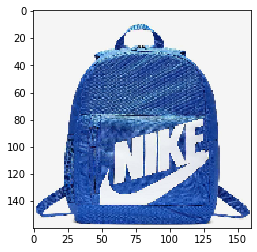

In [22]:
# Evaluate a single prediction
for imgs, _ in input_fn(test_data, is_eval=True).take(1):
    img_idx = 3
    plt.imshow(imgs["x"][img_idx] / 255)
    print(p[img_idx]['predictions'])
    if 0 < p[img_idx]['predictions'][0] < 1.5:
        print("It is SQUARE")
    elif 1.5 <= p[img_idx]['predictions'][0] < 2.5:
        print("It is TRAPEZOID")
    elif 2.5 <= p[img_idx]['predictions'][0] < 3.5:
        print("It is U_TRAPEZOID")
    elif 3.5 <= p[img_idx]['predictions'][0] < 4.5:
        print("It is CIRCLE")
    elif 4.5 <= p[img_idx]['predictions'][0] < 5.5:
        print("It is HALF_CIRCLE")
    elif 5.5 <= p[img_idx]['predictions'][0] < 6.5:
        print("It is U_HALF_CIRCLE")
    elif 6.5 <= p[img_idx]['predictions'][0] < 7.5:
        print("It is HOBO")
    elif 7.5 <= p[img_idx]['predictions'][0] < 8.5:
        print("It is BUCKET")
    elif 8.5 <= p[img_idx]['predictions'][0] < 9.5:
        print("It is BAKCPACK")

## Multi-task learning with the Head API

In [ ]:
# Need to disable the eager execution at this point
import numpy as np
import tensorflow as tf

In [ ]:
def multihead_input_fn(data, is_eval=False):
    features, labels = input_fn(data, is_eval=is_eval).make_one_shot_iterator().get_next() # Why?
    return features, {'head_nose': labels[:, 2:8:5], 'head_pose': tf.cast(labels[:, -1] - 1.0, tf.int32)}

In [ ]:
def multi_head_cnn_model_fn(features, labels, mode):

    dense = extract_features(features)

    # Predictions for each task
    predictions_nose = tf.layers.dense(inputs=dense, units=2)
    predictions_pose = tf.layers.dense(inputs=dense, units=5)
    logits = {'head_nose': predictions_nose, 'head_pose': predictions_pose}

    # Optimizer
    optimizer = tf.train.AdamOptimizer()

    # Double head
    regression_head = tf.contrib.estimator.regression_head(name='head_nose', label_dimension=2)
    classification_head = tf.contrib.estimator.multi_class_head(name='head_pose', n_classes=5)

    # Multi head combining two single heads
    multi_head = tf.contrib.estimator.multi_head([regression_head, classification_head])

    return multi_head.create_estimator_spec(features, mode, logits, labels, optimizer)

### Create the Estimator

In [ ]:
multitask_classifier = tf.estimator.Estimator(model_fn=multi_head_cnn_model_fn)

### Train & evaluate & test model

In [ ]:
# Train the model
multitask_classifier.train(input_fn=lambda: multihead_input_fn(train_data), steps=1000)

In [ ]:
multitask_classifier.evaluate(input_fn=lambda: multihead_input_fn(test_data, is_eval=True))

In [ ]:
p = list(multitask_classifier.predict(lambda: input_fn(test_data, is_eval=True)))
print(p[0])